# The  keras implementation of mobilenet v2

*load cifar10 as for test dataset*

In [1]:
!pip install keras
!pip install pydot
!pip install opencv-python

    100% |████████████████████████████████| 133kB 8.0MB/s 
  Running setup.py bdist_wheel for pydot ... - done
  Stored in directory: /root/.cache/pip/wheels/6a/a5/14/25541ebcdeaf97a37b6d05c7ff15f5bd20f5e91b99d313e5b4
Successfully built pydot


In [2]:
from keras.datasets import cifar10
import numpy as np
import os
import matplotlib.pyplot as plt
from random import randint
import cv2
%matplotlib inline

Using TensorFlow backend.


In [3]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 27s 0us/step


In [4]:
print(x_train.shape)
print(x_test.shape)
class_names = [
    'airplane', 
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

(50000, 32, 32, 3)
(10000, 32, 32, 3)


(-0.5, 31.5, 31.5, -0.5)

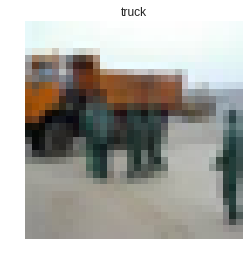

In [6]:
#show some random image
idx = randint(0,x_train.shape[0])
image = x_train[idx]
label = y_train[idx]
plt.imshow(image)
plt.title(class_names[int(label)])
plt.axis('off')

In [7]:
# save the data and make dir
train_path = 'data//train//'
test_path = 'data//test//'

#save the image
for i in range(len(x_train)):
  x = x_train[i]
  y = y_train[i]
  path = train_path + str(y[0])
  x = cv2.resize(x, (224, 224), interpolation=cv2.INTER_CUBIC)
  if not os.path.exists(path):
      os.makedirs(path)
  cv2.imwrite(path + '//' + str(i) + '.jpg', x)
print('Train data saved')
  
for i in range(len(x_test)):
  x = x_test[i]
  y = y_test[i]
  path = test_path + str(y[0])
  x = cv2.resize(x, (224, 224), interpolation=cv2.INTER_CUBIC)
  if not os.path.exists(path):
      os.makedirs(path)
  cv2.imwrite(path + '//' + str(i) + '.jpg', x)
print('Test data saved')

Train data saved
Test data saved


In [8]:
print(os.listdir(train_path))

['3', '4', '5', '9', '1', '6', '2', '8', '0', '7']


# Build the Mobilenet v2

*The constructure of network*

![替代文字](https://github.com/xiaochus/MobileNetV2/raw/master/images/net.jpg)

In [0]:
# import keras

"""MobileNet v2 models for Keras.
# Reference
- [Inverted Residuals and Linear Bottlenecks Mobile Networks for
   Classification, Detection and Segmentation]
   (https://arxiv.org/abs/1801.04381)
"""
from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout
from keras.layers import Activation, BatchNormalization, add, Reshape
from keras.applications.mobilenet import relu6, DepthwiseConv2D
from keras.utils.vis_utils import plot_model

from keras import backend as K

## *Def the conv2d layer and replace relu layer with relu6*

In [0]:
def _conv_block(inputs, filters, kernel, strides):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    return Activation(relu6)(x)

## *Def the bottleneck*

In [0]:
def _bottleneck(inputs, filters, kernel, t, s, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    tchannel = K.int_shape(inputs)[channel_axis] * t

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)

    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)

    if r:
        x = add([x, inputs])
    return x

## *Def the residual block*

In [0]:
def _inverted_residual_block(inputs, filters, kernel, t, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs, filters, kernel, t, strides)

    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, 1, True)

    return x

## *Build the whole model*

In [0]:
def MobileNetv2(input_shape, k):
    """MobileNetv2
    This function defines a MobileNetv2 architectures.
    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor.
        k: Integer, number of classes.
    # Returns
        MobileNetv2 model.
    """

    inputs = Input(shape=input_shape)
    x = _conv_block(inputs, 32, (3, 3), strides=(2, 2))

    x = _inverted_residual_block(x, 16, (3, 3), t=1, strides=1, n=1)
    x = _inverted_residual_block(x, 24, (3, 3), t=6, strides=2, n=2)
    x = _inverted_residual_block(x, 32, (3, 3), t=6, strides=2, n=3)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, strides=2, n=4)
    x = _inverted_residual_block(x, 96, (3, 3), t=6, strides=1, n=3)
    x = _inverted_residual_block(x, 160, (3, 3), t=6, strides=2, n=3)
    x = _inverted_residual_block(x, 320, (3, 3), t=6, strides=1, n=1)

    x = _conv_block(x, 1280, (1, 1), strides=(1, 1))
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, 1280))(x)
    x = Dropout(0.3, name='Dropout')(x)
    x = Conv2D(k, (1, 1), padding='same')(x)

    x = Activation('softmax', name='softmax')(x)
    output = Reshape((k,))(x)

    model = Model(inputs, output)

    return model

# Preprocess the data and Normalization

In [0]:
#import the necessary 
import os
import sys
import pandas as pd

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, Reshape, Activation
from keras.models import Model

In [0]:
# Hyperparameter
batch = 32
epoch = 10
num_classes = len(class_names)
image_size = 224
use_pretrained_weight = False
num_of_pretrained_classes = 0

In [0]:
def generate(batch, image_size):
  '''
  preprocess the dataset
  '''
  gen1 = ImageDataGenerator(
          rescale=1. / 255,
          shear_range=0.2,
          zoom_range=0.2,
          rotation_range=90,
          width_shift_range=0.2,
          height_shift_range=0.2,
          horizontal_flip=True)
  gen2 = ImageDataGenerator(rescale=1. /255)

  train_data = gen1.flow_from_directory(
          train_path,
          target_size=(image_size, image_size),
          batch_size=batch,
          class_mode='categorical')

  test_data = gen2.flow_from_directory(
          test_path,
          target_size=(image_size, image_size),
          batch_size=batch,
          class_mode='categorical')
  count1 = 0
  for root, dirs, files in os.walk(train_path):
      for each in files:
          count1 += 1

  count2 = 0
  for root, dirs, files in os.walk(test_path):
      for each in files:
          count2 += 1

  return train_data, test_data, count1, count2

In [32]:
train_data, test_data, count1, count2 = generate(batch, image_size)
print(count1, count2)

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
50000 10000


*Whether to load pretrained model*

In [0]:
def fine_tune(num_classes, weights, model):
    """Re-build model with current num_classes.
    # Arguments
        num_classes, Integer, The number of classes of dataset.
        tune, String, The pre_trained model weights.
        model, Model, The model structure.
    """
    model.load_weights(weights)

    x = model.get_layer('Dropout').output
    x = Conv2D(num_classes, (1, 1), padding='same')(x)
    x = Activation('softmax', name='softmax')(x)
    output = Reshape((num_classes,))(x)

    model = Model(inputs=model.input, outputs=output)

    return model

# Training

In [0]:
def train(batch, epochs, num_classes, size, weights, tclasses):
    """Train the model.
    # Arguments
        batch: Integer, The number of train samples per batch.
        epochs: Integer, The number of train iterations.
        num_classes, Integer, The number of classes of dataset.
        size: Integer, image size.
        weights, String, The pre_trained model weights.
        tclasses, Integer, The number of classes of pre-trained model.
    """

    train_generator, validation_generator, count1, count2 = generate(batch, size)

    if weights:
        model = MobileNetv2((size, size, 3), tclasses)
        model = fine_tune(num_classes, weights, model)
    else:
        model = MobileNetv2((size, size, 3), num_classes)

    opt = Adam()
    earlystop = EarlyStopping(monitor='val_acc', patience=30, verbose=0, mode='auto')
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    hist = model.fit_generator(
        train_generator,
        validation_data=validation_generator,
        steps_per_epoch=count1 // batch,
        validation_steps=count2 // batch,
        epochs=epochs,
        callbacks=[earlystop])

    if not os.path.exists('model'):
        os.makedirs('model')

    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv('model/hist.csv', encoding='utf-8', index=False)
    model.save_weights('model/weights.h5')


In [0]:
train(batch, epoch, num_classes, image_size, use_pretrained_weight, num_of_pretrained_classes)